In [3]:
# Ячейка 1: Импорты
import sys
sys.path.append('..')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time

from src.dataset_original import STEM4DDataset
from src.model_original import U_Net
from src.losses_original import CombinedLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Фиксируем seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)


Using device: cpu


In [4]:
# Ячейка 2: Загрузка данных
data_path = Path("../data")
results_path = Path("../results/original_unet")
results_path.mkdir(exist_ok=True, parents=True)

print("Loading data...")
low_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_Low_dose.npy")
high_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_High_dose.npy")

print(f"Low dose shape: {low_dose.shape}")
print(f"Low dose range: [{low_dose.min():.2f}, {low_dose.max():.2f}]")

# Вычисляем количество электронов на паттерн
electrons_per_pattern = low_dose.sum(axis=(2, 3)).mean()
print(f"Average electrons per pattern: {electrons_per_pattern:.1f}")

Loading data...
Low dose shape: (256, 256, 48, 48)
Low dose range: [0.00, 4.08]
Average electrons per pattern: 165.4


Bright field pixels: 1812 / 2304


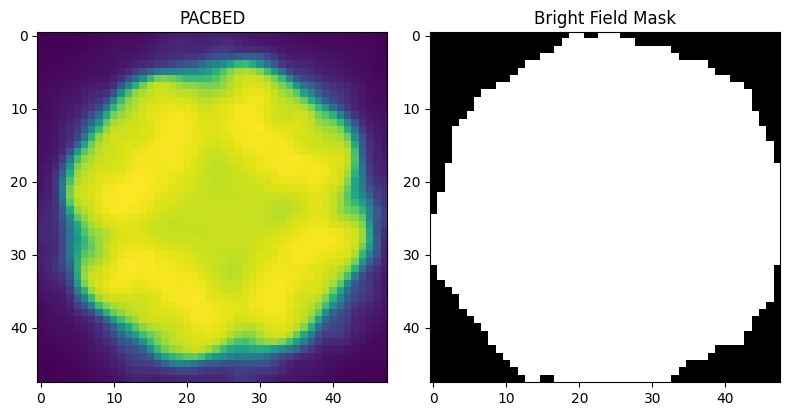

In [5]:
# Ячейка 3: Создание bright field маски
# PACBED из high dose для более точной маски
pacbed_high = np.mean(high_dose, axis=(0, 1))
threshold = 0.1 * pacbed_high.max()
bf_mask = pacbed_high > threshold

print(f"Bright field pixels: {bf_mask.sum()} / {bf_mask.size}")
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(pacbed_high, cmap='viridis')
plt.title('PACBED')
plt.subplot(122)
plt.imshow(bf_mask, cmap='gray')
plt.title('Bright Field Mask')
plt.tight_layout()
plt.show()

In [6]:
# Ячейка 4: Создание Dataset и DataLoader
batch_size = 8  # Как в оригинале
window_size = 3  # 3x3 окно

dataset = STEM4DDataset(
    noisy_data=low_dose,
    window_size=window_size,
    bright_field_mask=bf_mask
)

print(f"Dataset size: {len(dataset)}")

# Разделение на train/val (90/10)
n_samples = len(dataset)
n_val = int(n_samples * 0.1)
n_train = n_samples - n_val

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

Dataset size: 64516


In [8]:
# Ячейка 5: Инициализация модели
n_kernels = 64  # Размер из статьи (38M параметров)
model = U_Net(img_ch=8, output_ch=1, n_kernels=n_kernels).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss с регуляризацией из статьи
criterion = CombinedLoss(warmup_epochs=8, pacbed_weight=0.02, stem_weight=0.01)

# Устанавливаем целевые значения для регуляризации
target_pacbed = torch.from_numpy(bf_mask.astype(np.float32) * pacbed_high).to(device)
target_stem_sums = torch.from_numpy(low_dose.flatten().astype(np.float32)).to(device)
criterion.set_targets(target_pacbed, target_stem_sums)

# Оптимизатор - SGD как упоминается в статье
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Learning rate scheduler для итеративного уточнения (умножение на 0.8)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

Model parameters: 34,529,921


In [9]:
# Ячейка 6: Инициализация модели для сохранения общего количества электронов
print("Initializing model to preserve total electron count...")

# Вычисляем начальные STEM и PACBED из данных
noisy_stem = low_dose.sum(axis=(2, 3))
noisy_pacbed = low_dose.sum(axis=(0, 1))

# Делаем один проход для вычисления начального масштаба
model.eval()
with torch.no_grad():
    # Берем небольшую выборку для оценки
    sample_indices = np.random.choice(len(train_dataset), size=min(100, len(train_dataset)), replace=False)
    
    total_input_sum = 0
    total_output_sum = 0
    
    for idx in sample_indices:
        inputs, targets, _ = train_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)
        targets = targets.to(device)
        
        # Предсказание без масштабирования
        outputs = model(inputs)
        
        total_input_sum += targets.sum().item()
        total_output_sum += outputs.sum().item()
    
    # Вычисляем scale_factor
    if total_output_sum > 0:
        scale_factor = np.sqrt(total_input_sum / total_output_sum)
    else:
        scale_factor = 1.0
    
    # Устанавливаем в модель
    model.scale_factor.fill_(scale_factor)
    
    print(f"Initial scale factor: {scale_factor:.4f}")
    print(f"Average input sum: {total_input_sum/len(sample_indices):.2f}")
    print(f"Average output sum (before scaling): {total_output_sum/len(sample_indices):.2f}")
    print(f"Average output sum (after scaling): {(total_output_sum * scale_factor**2)/len(sample_indices):.2f}")


Initializing model to preserve total electron count...
Initial scale factor: 256.6629
Average input sum: 160.72
Average output sum (before scaling): 0.00
Average output sum (after scaling): 160.72


In [10]:
# Ячейка 7: Функции обучения
def train_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    criterion.set_epoch(epoch)
    total_loss = 0
    
    pbar = tqdm(loader, desc=f'Training epoch {epoch}')
    for batch_idx, (inputs, targets, indices) in enumerate(pbar):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, indices)
        
        # Передаем indices в loss для STEM регуляризации
        loss = criterion(outputs, targets, indices)
        
        loss.backward()
        
        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

def validate_epoch(model, loader, criterion, device, epoch):
    model.eval()
    criterion.set_epoch(epoch)
    total_loss = 0
    
    with torch.no_grad():
        for inputs, targets, indices in tqdm(loader, desc='Validation'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs, indices)
            loss = criterion(outputs, targets, indices)
            
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [11]:
# Ячейка 8: Основные параметры обучения из статьи
num_iterations = 10  # 10 refinement steps как в статье
epochs_per_iteration = 100  # Достаточно эпох для сходимости
total_epochs = 0

history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

print("Starting training with iterative refinement...")
print(f"Iterations: {num_iterations}, Initial LR: {optimizer.param_groups[0]['lr']}")
total_start_time = time.time()

for iteration in range(num_iterations):
    print(f"\n=== Iteration {iteration + 1}/{num_iterations} ===")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    iteration_start_time = time.time()
    
    for epoch in range(epochs_per_iteration):
        current_epoch = total_epochs + epoch
        
        train_loss = train_epoch(model, train_loader, criterion, optimizer, 
                               device, current_epoch)
        val_loss = validate_epoch(model, val_loader, criterion, device, 
                                current_epoch)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_iteration} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Сохраняем лучшую модель
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'iteration': iteration,
                'epoch': current_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss
            }, results_path / 'best_model_original.pth')
            print(f"✓ Saved best model at epoch {current_epoch}")
    
    total_epochs += epochs_per_iteration
    
    # Обновляем learning rate после каждой итерации (умножаем на 0.8)
    scheduler.step()
    
    iteration_time = time.time() - iteration_start_time
    print(f"Iteration completed in {iteration_time/60:.2f} minutes")

total_time = time.time() - total_start_time
print(f"\nTotal training time: {total_time/3600:.2f} hours")

# Визуализация истории обучения
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss', alpha=0.7)
plt.plot(history['val_loss'], label='Val Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History (Original U-Net Implementation)')
plt.legend()
plt.grid(True)
plt.savefig(results_path / 'training_history.png')
plt.show()

Starting training with iterative refinement...
Iterations: 10, Initial LR: 0.001

=== Iteration 1/10 ===
Learning rate: 0.001000


Training epoch 0:   7%|▋         | 531/7259 [11:16<2:22:45,  1.27s/it, loss=17238.7852]   


KeyboardInterrupt: 

In [ ]:
# Ячейка 9: Применение коррекций STEM и PACBED
print("\nApplying STEM and PACBED corrections...")

# Загружаем лучшую модель
checkpoint = torch.load(results_path / 'best_model_original.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Вычисляем коррекции как в оригинале
model.eval()
with torch.no_grad():
    # Сначала получаем предсказания без коррекций
    all_predictions = []
    all_indices = []
    
    for inputs, targets, indices in tqdm(val_loader, desc='Computing corrections'):
        inputs = inputs.to(device)
        outputs = model(inputs, indices)
        all_predictions.append(outputs.cpu())
        all_indices.extend(indices.numpy())
    
    predictions = torch.cat(all_predictions, dim=0)
    
    # Вычисляем предсказанные STEM и PACBED
    pred_stem = predictions.sum(dim=(2, 3)).numpy()
    pred_pacbed = predictions.sum(dim=0).squeeze().numpy()
    
    # Создаем коэффициенты коррекции
    mu = np.ones(len(dataset))
    for i, idx in enumerate(all_indices):
        x, y = dataset.valid_positions[idx]
        if pred_stem[i] > 0:
            mu[idx] = noisy_stem[x, y] / pred_stem[i]
    
    pacbed_correction = np.ones_like(pred_pacbed)
    pacbed_correction[pred_pacbed > 0] = noisy_pacbed[pred_pacbed > 0] / pred_pacbed[pred_pacbed > 0]
    
    # Устанавливаем коррекции в модель
    model.mu = torch.from_numpy(mu).float().to(device)
    model.PACBED = torch.from_numpy(pacbed_correction).float().to(device)

print("Corrections applied!")

In [ ]:
# Ячейка 10: Функция полного деноизинга
def denoise_full_dataset(model, noisy_data, bf_mask=None, batch_size=64, device='cpu'):
    """Применить деноизинг ко всему 4D STEM датасету"""
    scan_x, scan_y, det_x, det_y = noisy_data.shape
    denoised = np.zeros_like(noisy_data)
    
    # Создаем временный dataset
    temp_dataset = STEM4DDataset(noisy_data, window_size=3, bright_field_mask=bf_mask)
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    with torch.no_grad():
        all_outputs = []
        all_indices = []
        
        for inputs, targets, indices in tqdm(temp_loader, desc="Denoising"):
            inputs = inputs.to(device)
            outputs = model(inputs, indices)
            all_outputs.append(outputs.cpu().numpy())
            all_indices.extend(indices.numpy())
        
        # Размещаем результаты в правильные позиции
        outputs = np.concatenate(all_outputs, axis=0)
        for i, idx in enumerate(all_indices):
            x, y = temp_dataset.valid_positions[idx]
            denoised[x, y] = outputs[i, 0]
    
    # Копируем края (которые не были обработаны)
    offset = 1
    denoised[:offset, :] = noisy_data[:offset, :]
    denoised[-offset:, :] = noisy_data[-offset:, :]
    denoised[:, :offset] = noisy_data[:, :offset]
    denoised[:, -offset:] = noisy_data[:, -offset:]
    
    return denoised

# Применяем деноизинг
print("\nDenoising full dataset...")
denoised_data = denoise_full_dataset(model, low_dose, bf_mask, device=device)

# Сохраняем результат
np.save(results_path / 'denoised_original_unet.npy', denoised_data)

# Визуализация результатов
positions = [(50, 50), (100, 100), (150, 150)]
fig, axes = plt.subplots(len(positions), 3, figsize=(12, 12))

for i, (x, y) in enumerate(positions):
    vmax = low_dose[x, y].max()
    
    axes[i, 0].imshow(low_dose[x, y], cmap='viridis', vmax=vmax)
    axes[i, 0].set_title(f'Low Dose ({x}, {y})')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(denoised_data[x, y], cmap='viridis', vmax=vmax)
    axes[i, 1].set_title('Denoised (Original U-Net)')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(high_dose[x, y], cmap='viridis')
    axes[i, 2].set_title('High Dose (Reference)')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig(results_path / 'denoising_results.png', dpi=300)
plt.show()

print("\nDenoising completed!")